# ViOCD Baseline: Logistic Regression

Notebook này thiết lập một baseline (mức cơ sở) cho bài toán **Vietnamese Online Complaint Detection** sử dụng mô hình Logistic Regression truyền thống.

Mục tiêu:
1. Tái lập kết quả baseline thường thấy trong các bài báo NLP (như paper ViOCD).
2. So sánh hiệu năng với hệ thống Multi-Agent MAFA.
3. Xác định các trường hợp "dễ" mà mô hình đơn giản cũng bắt được, và các trường hợp "khó" cần đến Agent.

## Cấu hình
- **Feature**: TF-IDF (N-gram 1,2)
- **Model**: Logistic Regression (Solver: liblinear, Class Weight: Balanced)

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

# Cấu hình hiển thị
pd.set_option('display.max_colwidth', 200)
sns.set_style("whitegrid")

## 1. Tải dữ liệu (Train / Dev / Test)

In [22]:
try:
    # Load đầy đủ 3 tập dữ liệu
    train_df = pd.read_csv('../data/train.csv')
    dev_df = pd.read_csv('../data/dev.csv')
    test_df = pd.read_csv('../data/test.csv')
    
    print(f"Train size: {len(train_df)}")
    print(f"Dev size:   {len(dev_df)}")
    print(f"Test size:  {len(test_df)}")
    
    # Hiển thị mẫu từ tập train
    display(train_df.head())
    
except FileNotFoundError:
    print("Không tìm thấy đủ file dữ liệu (train/dev/test). Đang tạo dữ liệu giả lập...")
    # Dữ liệu giả lập
    data = {'review': ['Tốt', 'Tệ', 'Bình thường', 'Rất thích', 'Thất vọng'], 'label': [0, 1, 0, 0, 1]}
    train_df = pd.DataFrame(data)
    dev_df = pd.DataFrame(data)
    test_df = pd.DataFrame(data)
    print("Đã tạo dữ liệu giả lập.")

Train size: 4387
Dev size:   548
Test size:  549


,Unnamed: 0,review,review_tokenize,label,domain
0,0,gói hàng cẩn thận . chơi pubg với liên quân mượt với giá như này thì quá tốt,gói hàng cẩn_thận . chơi pubg với liên_quân mượt với giá_như này thì quá tốt,1,mobile
1,1,mình góp ý thật nhé.. đừng bắt phải đăng nhập zalo nữa mình muốn tải nhạc mà không được lấy lại tôi không zalo thì gửi tin nhắn mất tiền được mã kích hoạt lại không chính xác.. mình thấy 10 ngưòi ...,mình góp_ý thật nhé . . đừng bắt phải đăng_nhập zalo nữa mình muốn tải nhạc mà không được lấy lại tôi không zalo thì gửi tin nhắn mất tiền được mã kích_hoạt lại không chính_xác . . mình thấy 10 ng...,0,app
2,2,"máy khá đẹp,pin trâu vân tay nhạy nhận diện khuôn mặt nhanh nói chung ổn.tuy chơi game frE fire bị chậm khung hình không mượt lắm nhưng với giá giẫm ngày 1111 được aD mã giảm giá 200k còn hơn 2tr6...","máy khá đẹp , pin trâu vân tay nhạy nhận_diện khuôn_mặt nhanh nói_chung ổn . tuy chơi game frE fire bị chậm khung hình không mượt lắm nhưng với giá giẫm ngày 1111 được aD mã giảm_giá 200k còn hơn ...",0,mobile
3,3,"một mớ lỗi: không xem lại được bài test, không hiện link( ví dụ như là youtube khi chia sẻ) không copy được từ không biết để dịch. làm ơn cho về bản web đi","một mớ lỗi : không xem_lại được bài test , không hiện link ( ví_dụ như là youtube khi chia_sẻ ) không copy được từ không biết để dịch . làm_ơn cho về bản web đi",0,app
4,4,đặc mẫu xanh mà sao giao mẫu này vậy cửa hàng,đặc mẫu xanh mà sao giao mẫu này vậy cửa_hàng,0,fashion


## 2. Tiền xử lý dữ liệu
Áp dụng chuẩn hóa text cho cả 3 tập.

In [23]:
def basic_clean(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    # Giữ lại tiếng Việt và số
    text = re.sub(r'[^a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ0-9\s]', '', text)
    return text.strip()

text_col = 'review' if 'review' in train_df.columns else 'text'
label_col = 'label'

print(f"Sử dụng cột text: {text_col}")

train_df['clean_text'] = train_df[text_col].apply(basic_clean)
dev_df['clean_text'] = dev_df[text_col].apply(basic_clean)
test_df['clean_text'] = test_df[text_col].apply(basic_clean)

Sử dụng cột text: review


## 3. Tuning trên tập Dev

Sử dụng **Grid Search** trên tập `Dev` để tìm tham số `C` tốt nhất cho Logistic Regression.
Đây là bước quan trọng để tối ưu hóa hiệu năng thay vì dùng tham số mặc định.

In [24]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV

# Gộp Train và Dev để dùng PredefinedSplit cho GridSearchCV
# (GridSearchCV mặc định dùng Cross-Validation, nhưng ta muốn fix tập Dev cụ thể)
X_train = train_df['clean_text']
y_train = train_df[label_col]
X_dev = dev_df['clean_text']
y_dev = dev_df[label_col]

# Tạo vectorizer chung
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.9)
X_train_vec = vectorizer.fit_transform(X_train)
X_dev_vec = vectorizer.transform(X_dev)

# Nối dữ liệu train và dev
import scipy.sparse as sp
X_combined = sp.vstack((X_train_vec, X_dev_vec))
y_combined = np.concatenate((y_train, y_dev))

# Tạo split index: -1 cho mẫu train, 0 cho mẫu dev
split_index = [-1] * len(X_train) + [0] * len(X_dev)
pds = PredefinedSplit(test_fold=split_index)

# Grid Search tìm C
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(
    LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42),
    param_grid,
    cv=pds,  # Sử dụng PredefinedSplit
    scoring='f1_macro', # Hoặc 'f1' nếu quan tâm class 1
    verbose=1,
    n_jobs=-1
)

print("Bắt đầu Tuning trên tập Dev...")
grid.fit(X_combined, y_combined)

print(f"\nBest C: {grid.best_params_['C']}")
print(f"Best Dev F1 Score: {grid.best_score_:.4f}")

# Lấy mô hình tốt nhất
best_model = grid.best_estimator_

Bắt đầu Tuning trên tập Dev...
Fitting 1 folds for each of 5 candidates, totalling 5 fits

Best C: 100
Best Dev F1 Score: 0.9251


## 4. Đánh giá cuối cùng trên tập Test

=== KẾT QUẢ TRÊN TẬP TEST ===

                   precision    recall  f1-score   support

Non-Complaint (0)       0.90      0.93      0.92       279
    Complaint (1)       0.93      0.89      0.91       270

         accuracy                           0.91       549
        macro avg       0.91      0.91      0.91       549
     weighted avg       0.91      0.91      0.91       549



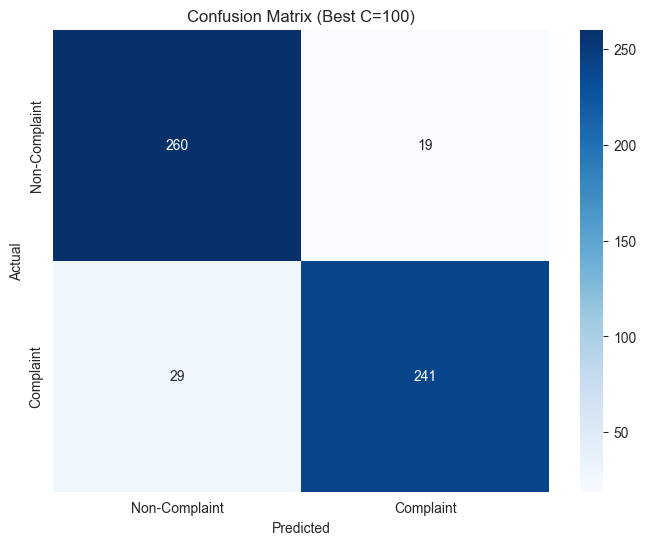

In [25]:
# Transform tập test
X_test_vec = vectorizer.transform(test_df['clean_text'])
y_test_true = test_df[label_col]

# Dự đoán
y_test_pred = best_model.predict(X_test_vec)

# Báo cáo
print("=== KẾT QUẢ TRÊN TẬP TEST ===\n")
print(classification_report(y_test_true, y_test_pred, target_names=['Non-Complaint (0)', 'Complaint (1)']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_true, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Complaint', 'Complaint'],
            yticklabels=['Non-Complaint', 'Complaint'])
plt.title(f'Confusion Matrix (Best C={grid.best_params_["C"]})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 5. Phân tích lỗi (Error Analysis)
Xem những câu nào mô hình dự đoán sai để hiểu điểm yếu của Logistic Regression.

In [26]:
test_df['predicted'] = y_test_pred
errors = test_df[test_df[label_col] != test_df['predicted']]

print(f"Số lượng mẫu sai: {len(errors)}")
print("\nCác mẫu dự đoán sai tiêu biểu:")
display(errors[[text_col, label_col, 'predicted']].head(10))

Số lượng mẫu sai: 48

Các mẫu dự đoán sai tiêu biểu:


,review,label,predicted
52,ủa sao tải rồi mà không có server để chơi mà mới đầu vô thấy game đánh nhau ùm sèo cũng hơi thú vị hi vọng game sẽ ra sever đánh giá 5star luôn không nói nhiều,1,0
53,tôi muốn hỏi tại sao? tại sao? tại sao??? tại sao các bạn lại làm một game hay như vậy để những người đã có tí tủi như tôi cũng dành thời gian để chơi??? thật tiếc cho những ai vẫn còn mang tư duy...,1,0
62,"hay có thể luyện viết kan gì i và có phần đọc báo. nhưng cho mình hỏi làm sao biết cách ghi khi tra từ ,viết lúc nó đổi hiragana lúc thì kan gì i, tôi chưa rõ lắm. mong giúp đỡ. cảm ơn.",1,0
65,mình nói ngắn gọn cho các bạn mà hay gặp lỗi văng game để sửa nhé. các bạn dùng android thì lên youtube xem cách bật chế độ nhà phát triển. sau đó vào chế độ này. tìm mục giới hạn các xử lí nền và...,1,0
67,"game rất hay, các con vật rất dễ thương, nhất là bé gấu trúc, nhưng mong nhà phát hành chỉnh sửa lại con bò để cho dễ nhận biết hơn, tôi rất thích tựa game này đúng với sở thích sinh tồn của tôi. ...",0,1
95,dat một noi giao hang một duong cửa hàng lam an nhu ke,0,1
98,"chất son siêu thích, mềm mịn vô cùng, môi mình hay bị khô nhưng tô son vào rất mượt, thích lắm. màu nâu đất pha đỏ nhìn lạ lạ. mua giá khuyến mãi chỉ còn 70k nhưng chất lượng ngoài mong đợi",1,0
126,ứng dụng này có đảm bảo bảo mật thông tin cá nhân của người dùng không và dựa trên nguyên tắc nào để tin tưởng cho bảo mật đó?!,1,0
143,sản phẩm đẹp có đều thun quần nhỏ lắm ☹,0,1
147,game muốn thu nhập cao thì phải chiều lòng người chơi là phần nhiều sau đấy càng ngày họ sẽ càng yêu thích và cống hiến hết mình cho game lúc đấy sẽ nhiều người nạp game và thu nhập sẽ cao nếu như...,1,0


## Kết luận

Baseline Logistic Regression cung cấp một thước đo nhanh về độ khó của dữ liệu.
- Nếu F1-score > 0.85: Bài toán khá rõ ràng, mô hình đơn giản làm tốt.
- Nếu F1-score < 0.70: Bài toán khó, cần sự can thiệp của các mô hình Deep Learning hoặc hệ thống Multi-Agent để hiểu ngữ cảnh sâu hơn.